<a href="https://colab.research.google.com/github/KatBCN/ML-PropertyAssessment/blob/main/ML_Modeling_LinearRegression2_PropertyAssessment_Buffalo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

June 6: Using newly imputed training data from the imputed folder

In [1]:
# import libraries
from google.colab import drive 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import power_transform
#from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from scipy import stats
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

# set options
pd.set_option('display.max_columns', None) 
sns.set()

# mount drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ML/ML-Project/data/
%ls 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ML/ML-Project/data
imputed/  initial_splits/  metadata/  preprocessed/  source_data/


This notebook uses data from the preprocessed data folder.

In [2]:
# load train data
df = pd.read_pickle("/content/drive/MyDrive/ML/ML-Project/data/imputed/train_BuffaloProperty_ohe_imputer3.pkl")


- Imputed folder: The training data set has 35,921 rows and 22 columns.

In [3]:
df.shape

(35921, 22)

😔  The datatypes got messed up after imputation and conversions from one hot encoding - need to correct datatypes at end of pre-processing.

In [4]:
df.dtypes

Front                         float64
Depth                         float64
Sale Price                    float64
Year Built                    float64
Total Living Area             float64
# of Fireplaces               float64
# of Beds                     float64
# of Baths                    float64
Latitude                      float64
Longitude                     float64
TotalBaths                    float64
Property Class Description     object
Previous Property Class        object
Overall Condition              object
Building Style                 object
Heat Type                      object
Basement Type                  object
Neighborhood                   object
SameOwnerLastName              object
OwnershipType                  object
Sale Type                      object
Total Value                   float64
dtype: object

In [5]:
df['OwnershipType'].value_counts()

Person         32436
Corporation     3388
Buffalo           97
Name: OwnershipType, dtype: int64

In [6]:
df["Property Class Description"].describe()

count                   35921
unique                      2
top       ONE FAMILY DWELLING
freq                    20969
Name: Property Class Description, dtype: object

In [7]:
df['Property Class Description'].value_counts()

ONE FAMILY DWELLING    20969
TWO FAMILY DWELLING    14952
Name: Property Class Description, dtype: int64

In the linear regression, we are only interested in numeric variables, so I will define which columns are numeric.

In [8]:
# select numeric columns
cols = df.select_dtypes(include=np.number).columns.tolist()
cols

['Front',
 'Depth',
 'Sale Price',
 'Year Built',
 'Total Living Area',
 '# of Fireplaces',
 '# of Beds',
 '# of Baths',
 'Latitude',
 'Longitude',
 'TotalBaths',
 'Total Value']

There are no missing values in this data, because it has been pre-processed with outlier detection and imputation.

In [9]:
print("Count of null values per numeric column:")
print(df[cols].isna().sum())

Count of null values per numeric column:
Front                0
Depth                0
Sale Price           0
Year Built           0
Total Living Area    0
# of Fireplaces      0
# of Beds            0
# of Baths           0
Latitude             0
Longitude            0
TotalBaths           0
Total Value          0
dtype: int64


Sale Price may not be a very reliable variable to use. The imputation allowed a nonrealistic value to appear which is negative. The imputer should be checked to make sure 0 is the minimum imputation value.

We still have Front and Total Living Area minimum values of 1, which I thought would be outliers...

In [10]:
df.describe(include='all')

,Front,Depth,Sale Price,Year Built,Total Living Area,# of Fireplaces,# of Beds,# of Baths,Latitude,Longitude,TotalBaths,Property Class Description,Previous Property Class,Overall Condition,Building Style,Heat Type,Basement Type,Neighborhood,SameOwnerLastName,OwnershipType,Sale Type,Total Value
count,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921.000000,35921,35921,35921,35921,35921,35921,35921,35921,35921,35921,35921.00000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,12,5,18,4,4,36,2,3,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ONE FAMILY DWELLING,ONE FAMILY DWELLING,3,08,2,4,South Park,Different name,Person,Real Sale,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20969,20890,32307,30855,29811,27644,2863,27225,32436,21439,NaN
mean,36.007668,118.404294,65721.067681,1919.137218,1816.484670,0.137691,4.054481,1.548184,42.910772,-78.622463,1.692464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62981.46104
std,8.918524,23.124733,60519.755570,24.527781,615.492584,0.405385,1.303909,0.545249,0.034926,4.154282,0.611045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52493.43274
min,5.000000,17.000000,0.000000,1800.000000,401.000000,0.000000,0.000000,0.000000,42.832090,-78.908661,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.00000
25%,30.000000,105.000000,26000.000000,1900.000000,1325.000000,0.000000,3.000000,1.000000,42.890035,-78.864922,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32000.00000
50%,33.000000,115.000000,49000.000000,1920.000000,1708.000000,0.000000,4.000000,2.000000,42.917171,-78.834920,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48900.00000
75%,40.000000,130.000000,84000.000000,1927.000000,2244.000000,0.000000,5.000000,2.000000,42.940270,-78.814865,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74000.00000


I will create a new column called "Age" which is the year 2020 - Year Built

In [11]:
df["Age"] = 2020 - df["Year Built"]

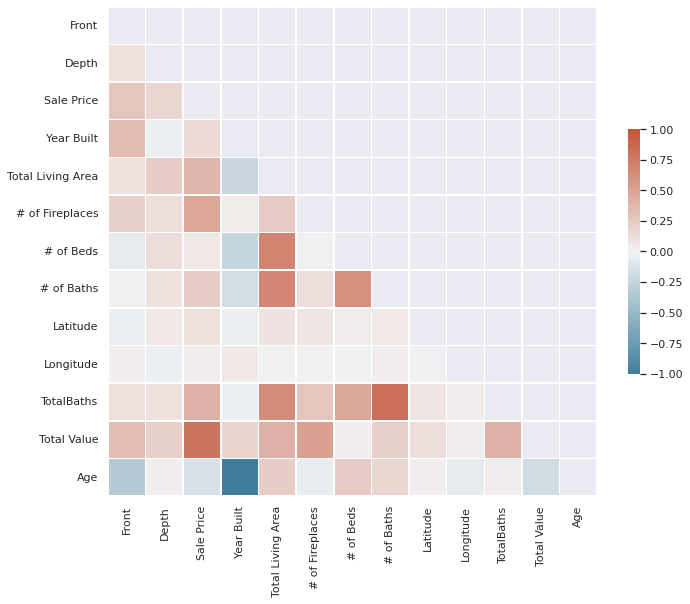

In [12]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin= -1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

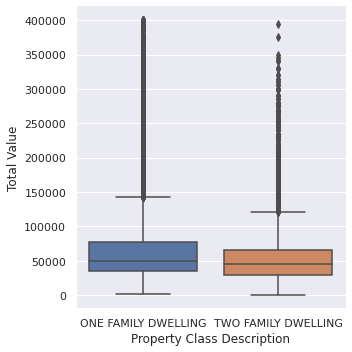

In [13]:
sns.catplot(x="Property Class Description", y="Total Value", kind="box", data=df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text major ticklabel objects>)

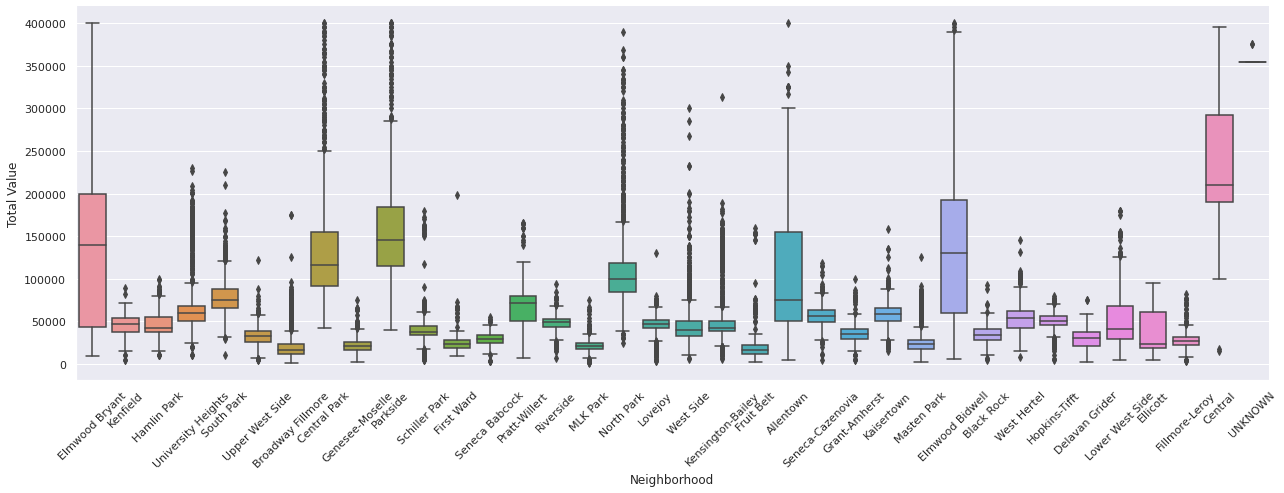

In [14]:

sns.catplot(x="Neighborhood", y="Total Value", kind="box", data=df, height=6, aspect=3)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

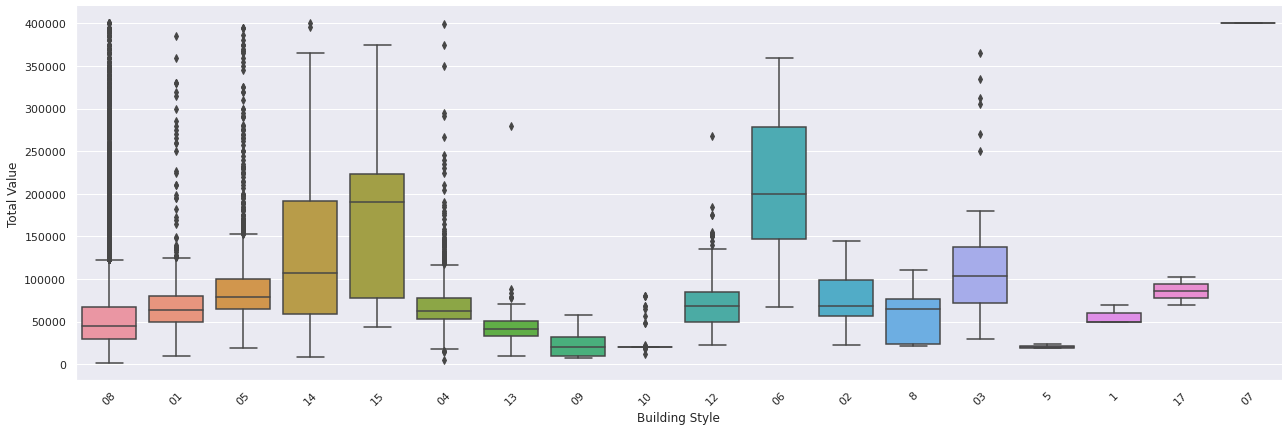

In [15]:
sns.catplot(x="Building Style", y="Total Value", kind="box", data=df, height=6, aspect=3)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

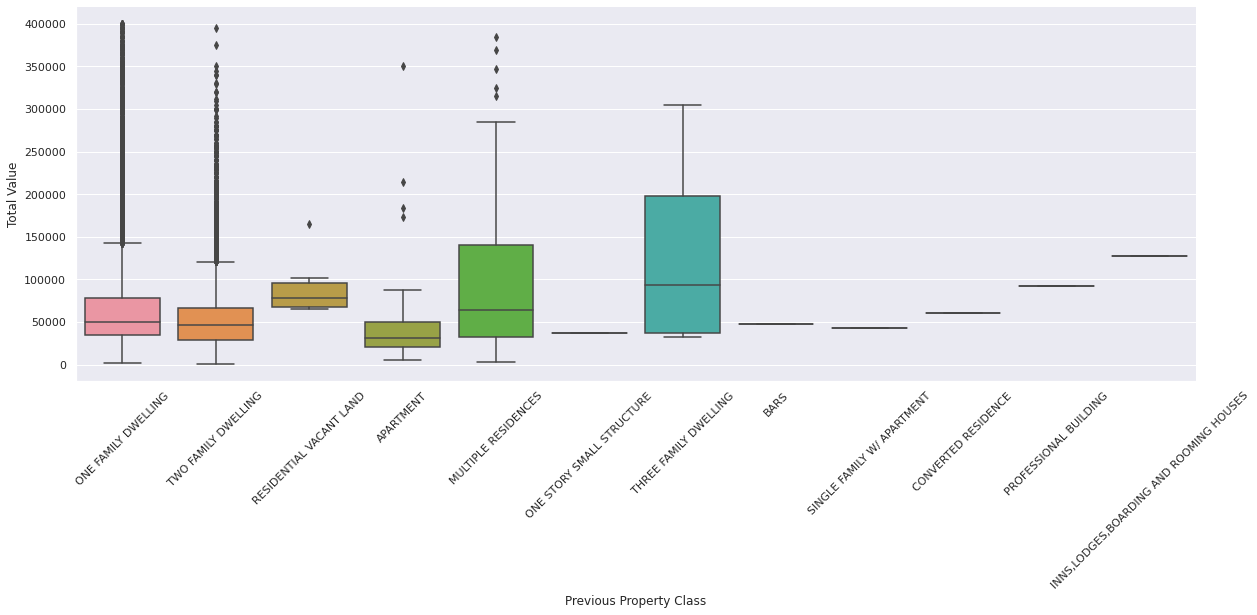

In [16]:
sns.catplot(x="Previous Property Class", y="Total Value", kind="box", data=df, height=6, aspect=3)
plt.xticks(rotation=45)

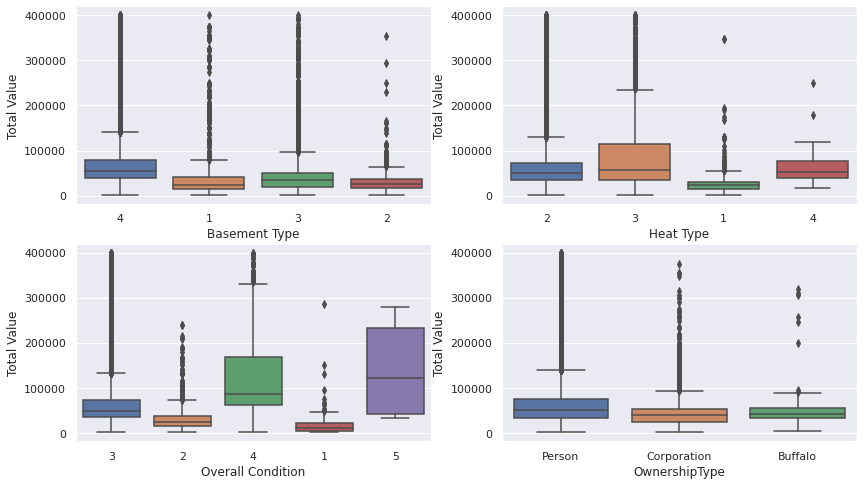

In [17]:
#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize = (14,8))

#create boxplot in each subplot
sns.boxplot(data=df, x='Basement Type', y='Total Value', ax=axes[0,0])
sns.boxplot(data=df, x='Heat Type', y='Total Value', ax=axes[0,1])
sns.boxplot(data=df, x='Overall Condition', y='Total Value', ax=axes[1,0])
sns.boxplot(data=df, x='OwnershipType', y='Total Value', ax=axes[1,1])

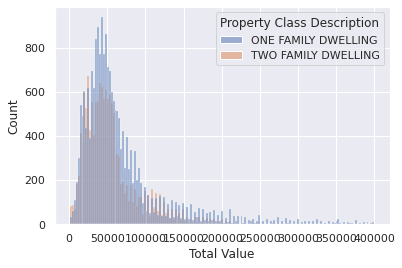

In [18]:
sns.histplot(data=df, x='Total Value', hue = "Property Class Description")

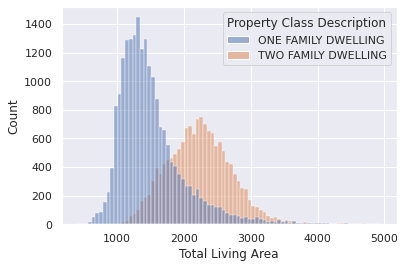

In [19]:
sns.histplot(data=df, x='Total Living Area', hue="Property Class Description")

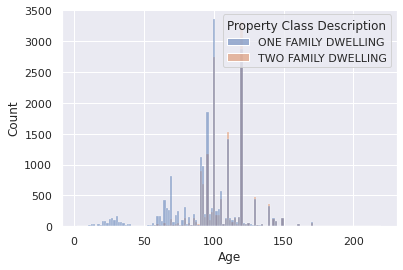

In [69]:
sns.histplot(data=df, x='Age', hue="Property Class Description")

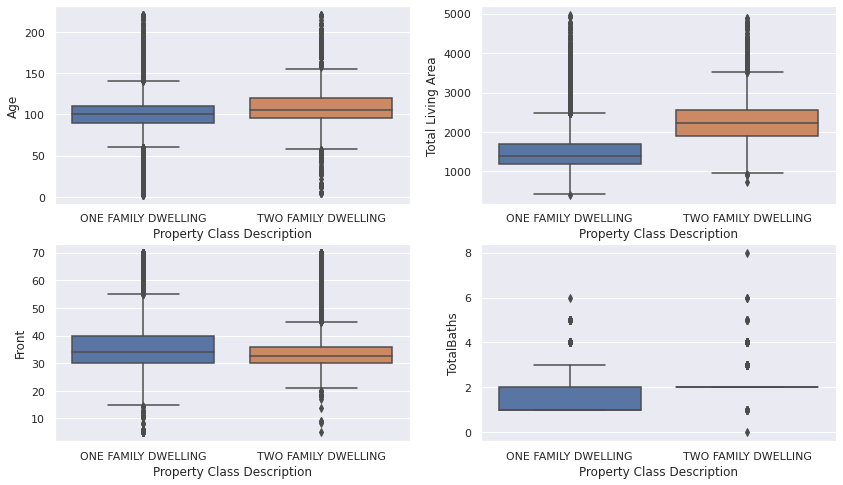

In [21]:
#define plotting region (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize = (14,8))

#create boxplot in each subplot
sns.boxplot(data=df, x='Property Class Description', y='Age', ax=axes[0,0])
sns.boxplot(data=df, x='Property Class Description', y='Total Living Area', ax=axes[0,1])
sns.boxplot(data=df, x='Property Class Description', y='Front', ax=axes[1,0])
sns.boxplot(data=df, x='Property Class Description', y='TotalBaths', ax=axes[1,1])

In [22]:
#sns.histplot(data=df, x='Front')

In [23]:
#sns.histplot(data=df, x='Depth')

In [24]:
#sns.histplot(data=df, x='Latitude', hue="Property Class Description")

In [25]:
#sns.histplot(data=df, x='Longitude', hue="Property Class Description")

Sale Price may not be the most reliable variable since it was imputed.

In [26]:
#sns.histplot(data=df, x='Sale Price')

* [sklearn.preprocessing.PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
* [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline)
* [How to Transform Target Variables for Regression in Python](https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/)

## Functions for running Regression Models

Regression Metrics:
- MSE: Mean squared error, closer to 0 is better. Our target is a large value, so this is expected to be large.
- RMSE: Square root of the mean square error which is expressed in units of the target. Closer to 0 is better.
- MAE: Mean Absolute Error
- Median Absolute Error is more robust to outliers.
- R2 score / Coefficient of Determination: the amount of variance explained by the model, and a goodness of fit. Closer to 1 is better.

Reference:
[Sklearn Regression Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

In [27]:
def getRegressionMetrics (target, prediction):
  """
  Provided a vector of the target and a vector of the prediction, this
  function prints the regression metrics associated with the data.
  """
  # The mean squared error: units not meaningful, but smaller is better
  print("Mean squared error: %.2f" % mean_squared_error(target, prediction))
  # The root mean squared error: expressed in units of target
  print("Root Mean squared error: %.2f" % np.sqrt(mean_squared_error(target, prediction)))
  # The mean absolute error
  print("Mean absolute error: %.2f" % mean_absolute_error(target, prediction))
  # The median absolute error: more robust to outliers
  print("Median absolute error: %.2f" % median_absolute_error(target, prediction))
  # The coefficient of determination: 1 is perfect prediction
  print("Coefficient of determination: %.2f" % r2_score(target, prediction))

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
def getPredictionPlot (target, prediction, title):
  """
  Provided a vector of the target and a vector of the prediction, this
  function produces a scatter plot and regression line. The title is a string
  which is expected to be the name of the model.
  """
  # Create a figure for 2 subplots (1 row, 2 columns)
  fig, ax = plt.subplots(1, 2, figsize = (14,6))

  # Create first subplot
  ax[0].scatter(target, prediction)
  ax[0].set_xlabel('Target Values')
  ax[0].set_ylabel('Predicted Values')
  ax[0].set_title('Total Value Predictions')
  # overlay the regression line
  z = np.polyfit(target, prediction, 1)
  p = np.poly1d(z)
  ax[0].plot(target,p(target), color='magenta')
  ax[0].tick_params('x', labelrotation=90)


  #Create second subplot
  # define residuals
  residuals = target - prediction
  # Fit a normal distribution to the residuals:
  mu, std = norm.fit(residuals)
  # plot residuals
  ax[1].hist(residuals, bins=50, density=True)
  # Plot the PDF.
  xmin, xmax = ax[1].get_xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  ax[1].plot(x, p, 'k', linewidth=2, color='magenta', label="mu:{:.2f}, std:{:.2f}".format(mu, std))
  ax[1].legend(loc="upper right")
  ax[1].set_title ("Residuals Histogram with Normal Curve")
  ax[1].set_xlabel('Residuals')
  ax[1].set_ylabel('Density')
  ax[1].tick_params('x', labelrotation=90)


  fig.suptitle(title)
  # Show the figure
  fig.show()

In [29]:
def fitLRModelPipeline(LRmodel, training_df, regression_cols):
  """
  Provide an object that is an sklearn linear regression model to train,
  the dataframe of training data, and a list of columns to use in regression.
  Returns: pipeline object that can be used to make predictions, and the
  matrices train_x and train_y.
  """
  train_x = df[regression_cols]
  train_y = df["Total Value"]

  # define numeric and categorical features
  numeric_features = train_x.select_dtypes(include=np.number).columns.tolist()
  object_columns = train_x.select_dtypes(include='object').columns.tolist()
  # convert object type columns to category type
  for col in object_columns:
    train_x[col] = train_x[col].astype("category")
  categorical_features = train_x.select_dtypes(include='category').columns.tolist()

  categorical_transformer = OneHotEncoder(handle_unknown="ignore")

  # numeric features are not processed
  # categorical features are one hot encoded
  preprocessor = ColumnTransformer(
      transformers=[
          ("cat", categorical_transformer, categorical_features),
      ]
  )
  # define the pipeline
  pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                            ('model', LRmodel)])

  #track time to train model
  start_time = time.time()

  # fit pipeline
  pipeline.fit(train_x, train_y)
  train_time = time.time() - start_time
  print (pipeline.named_steps['model'], "training time:", train_time)

  # get weights of model
  weights = pipeline.named_steps['model'].coef_

  # get intercept of model
  intercept = pipeline.named_steps['model'].intercept_

  # Access some info about the model.
  print('Coefficients: \n', weights)
  print('Intercept: \n', intercept)
  
  return pipeline, train_x, train_y


In [30]:
def evaluatePerformance(target, prediction):
  """
  """
  # Call to get regression metrics
  getRegressionMetrics(target, prediction)
  # Print a sample of predictions vs. the target
  print()
  print('Sample of 10 predictions vs. target:')
  print('Predicted values: ', np.round(prediction)[:10])
  print('Target values: ' ,target[:10])


## Ordinary least squares Linear Regression

In [31]:
# define the model
LRmodel = LinearRegression()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths"]
# save and fit the pipeline
OLSpipeline, train_x, train_y = fitLRModelPipeline(LRmodel, df, regression_cols)

LinearRegression() training time: 0.0638587474822998
Coefficients: 
 [  4389.62943633  -4389.62943669  36526.26511735 -36734.6525652
 -48887.74850457 158861.48015928  67955.48819432 -41540.26534668
 -36199.69886761  68862.42251716  70315.9115367  -43231.5204851
 -46011.93755742 -45665.14532701 -48516.58261446 -31950.7512901
 -23005.1076902  -21522.88130971 -12799.32037553 -26078.39737335
 -24446.41794559 -26314.45405664 -14730.87546501 -48572.17249446
 -43213.260328    37143.18484779  86236.51084477  -8758.24438165
 -23159.45974631 -30742.20134015 -41686.06520419 -13686.37872444
   5942.27714609 283852.36202342  -5294.54473815 -36832.46075981
 -15341.43189885 -20773.92599656]
Intercept: 
 70346.89756595224


In [32]:
# save predictions from data
y_pred_train = OLSpipeline.predict(train_x)

In [33]:
# evaluate performance of predictions on target
evaluatePerformance(train_y, y_pred_train)

Mean squared error: 1178757907.56
Root Mean squared error: 34333.04
Mean absolute error: 19215.90
Median absolute error: 10290.11
Coefficient of determination: 0.57

Sample of 10 predictions vs. target:
Predicted values:  [145052.  48658.  42952.  69442.  80679.  37904.  17070. 142692.  17441.
  37904.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64


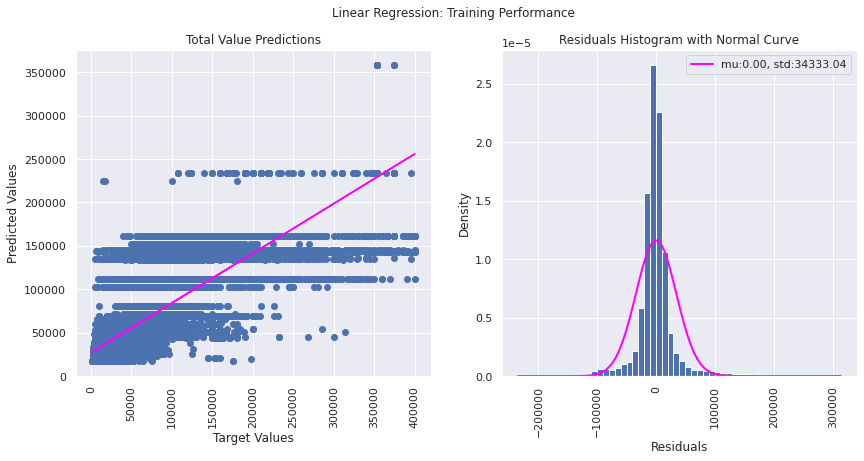

In [34]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Linear Regression: Training Performance")

I will re-run the model using more categorical variables.

In [35]:
# define the model
LRmodel = LinearRegression()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths", "Overall Condition", "Building Style", 
                   "Heat Type"]
# save and fit the pipeline
OLSpipeline, train_x, train_y = fitLRModelPipeline(LRmodel, df, regression_cols)

LinearRegression() training time: 0.24627351760864258
Coefficients: 
 [  2878.61291958  -2878.61292645  31512.25427716 -30538.78876989
 -43739.10818155 121276.90160926  66482.92909509 -35883.34135464
 -37700.69899035  70150.10049148  69055.53291688 -37000.50436608
 -39029.60701554 -43771.30952744 -41537.48191463 -26884.23685651
 -17923.39071179 -16586.90885288  -7512.46259853 -21000.69679058
 -19336.43365511 -19920.047119   -15729.07753175 -43115.0217123
 -41259.85170266  39440.66052122  85714.01996494 -31313.04415716
 -17382.29850147 -25140.08318133 -33858.60786414  -9896.55604155
   9097.41550966 227502.83343043   -451.91973705 -31117.65052546
 -14891.2659831  -17712.25417154 -25301.95261429 -21972.77236219
  -9995.11811992  20300.00526057  36969.83783624 -20167.81734396
   1694.94712043  23158.50928942 -23051.11204514   4805.87023068
  61710.79402876 240648.50289317 -23332.56747545 -47183.18820046
 -26735.70928358 -33361.12845244  -9711.27683395 -26803.22460192
  -2260.37089315  104

In [36]:
# save predictions from data
y_pred_train = OLSpipeline.predict(train_x)

In [37]:
# evaluate performance of predictions on target
evaluatePerformance(train_y, y_pred_train)

Mean squared error: 1072310385.78
Root Mean squared error: 32746.15
Mean absolute error: 18162.59
Median absolute error: 9532.94
Coefficient of determination: 0.61

Sample of 10 predictions vs. target:
Predicted values:  [136019.  33985.  43283.  69676.  76061.  35846.  17467. 145093.  19669.
  35846.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64


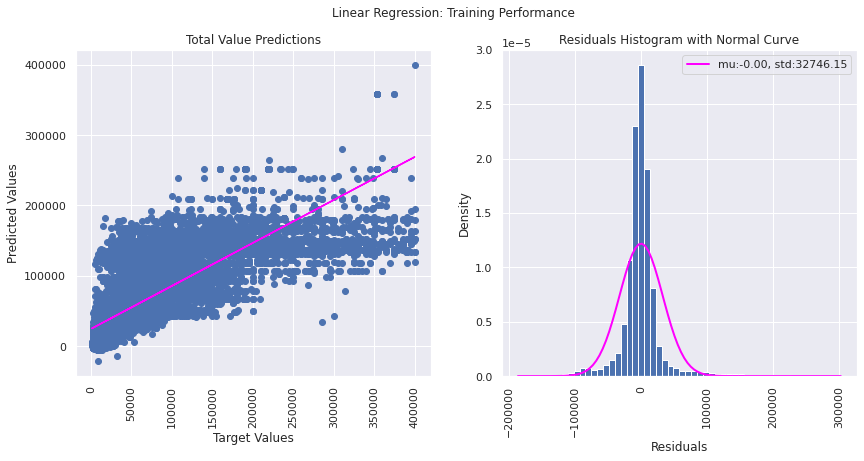

In [38]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Linear Regression: Training Performance")

## Linear Model trained with L1 prior as regularizer (aka the Lasso)

In [39]:
# define the model
LRmodel = Lasso()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths"]
# save and fit the pipeline
LassoPipeline, train_x, train_y = fitLRModelPipeline(LRmodel, df, regression_cols)

Lasso() training time: 6.623858451843262
Coefficients: 
 [ 8.78114269e+03 -1.50240548e-06  5.88446246e+04 -1.42470250e+04
 -2.64549514e+04  1.81035011e+05  9.03253007e+04 -1.90909601e+04
 -1.36403097e+04  9.12523981e+04  9.26759834e+04 -2.07747414e+04
 -2.34999521e+04 -2.31476551e+04 -2.60764855e+04 -9.44808879e+03
 -5.52180392e+02  8.58687101e+02  9.57983287e+03 -3.63003298e+03
 -2.01802817e+03 -3.87251608e+03  7.56718961e+03 -2.60982337e+04
 -2.07652160e+04  5.95442894e+04  1.08616558e+05  1.35496261e+04
 -7.22293585e+02 -8.30416837e+03 -1.91859957e+04  8.70087403e+03
  2.83450344e+04  3.02275894e+05  1.70976134e+04 -1.43815039e+04
  6.99879053e+03  1.60448796e+03]
Intercept: 
 43540.16721178389


In [40]:
# save predictions from data
y_pred_train = LassoPipeline.predict(train_x)

In [41]:
# evaluate performance of predictions on target
evaluatePerformance(train_y, y_pred_train)

Mean squared error: 1178763857.97
Root Mean squared error: 34333.13
Mean absolute error: 19215.48
Median absolute error: 10303.28
Coefficient of determination: 0.57

Sample of 10 predictions vs. target:
Predicted values:  [144997.  48691.  42988.  69419.  80666.  37940.  17085. 142647.  17464.
  37940.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64


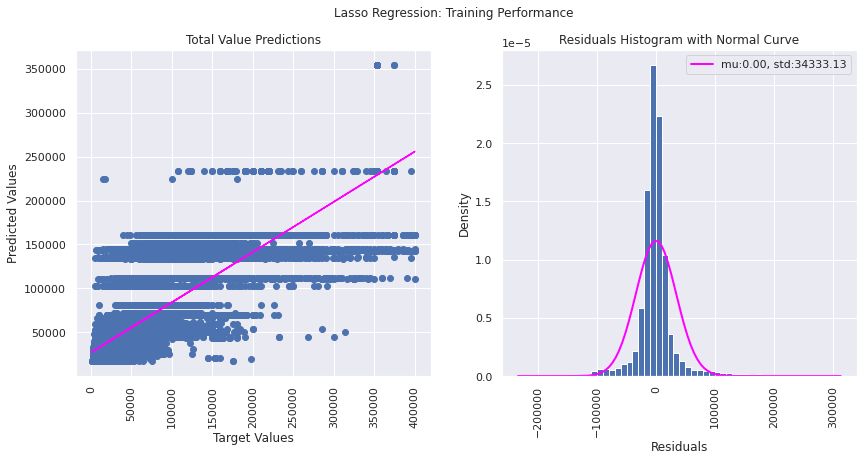

In [42]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Lasso Regression: Training Performance")

Running the model with more categorical variables.

In [43]:
# define the model
LRmodel = Lasso()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths", "Overall Condition", "Building Style", 
                   "Heat Type"]
# save and fit the pipeline
LassoPipeline, train_x, train_y = fitLRModelPipeline(LRmodel, df, regression_cols)

Lasso() training time: 6.0416624546051025
Coefficients: 
 [ 5.75064321e+03 -6.49044904e-07  4.93928159e+04 -1.25115178e+04
 -2.57625610e+04  1.38972538e+05  8.44045630e+04 -1.78979290e+04
 -1.95589097e+04  8.80756659e+04  8.70100075e+04 -1.90354823e+04
 -2.09625020e+04 -2.57177816e+04 -2.35634439e+04 -8.85677621e+03
  0.00000000e+00  1.30418261e+03  1.03998989e+04 -3.02270106e+03
 -1.37250099e+03 -1.95006393e+03  2.12433015e+03 -2.51084037e+04
 -2.32768256e+04  5.73664492e+04  1.03650396e+05 -1.32197479e+04
  5.41670974e+02 -7.16770550e+03 -1.58179997e+04  8.01472052e+03
  2.70334750e+04  2.41368412e+05  1.74764065e+04 -1.31351305e+04
  3.00094395e+03  2.02204033e+02 -2.09871253e+04 -1.77655205e+04
 -5.77688279e+03  2.45175537e+04  3.72294338e+04  0.00000000e+00
  2.12077933e+04  4.24689991e+04 -2.84913760e+03  2.49110462e+04
  7.88950045e+04  2.24891938e+05 -3.16368748e+03 -2.56929160e+04
 -0.00000000e+00 -1.26491366e+04  1.02104390e+04 -6.07012640e+03
  1.77665079e+04  3.07576662e+04

In [44]:
# save predictions from data
y_pred_train = LassoPipeline.predict(train_x)

In [45]:
# evaluate performance of predictions on target
evaluatePerformance(train_y, y_pred_train)

Mean squared error: 1072396954.99
Root Mean squared error: 32747.47
Mean absolute error: 18162.26
Median absolute error: 9533.10
Coefficient of determination: 0.61

Sample of 10 predictions vs. target:
Predicted values:  [136023.  34002.  43263.  69653.  76047.  35878.  17500. 145061.  19699.
  35878.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64


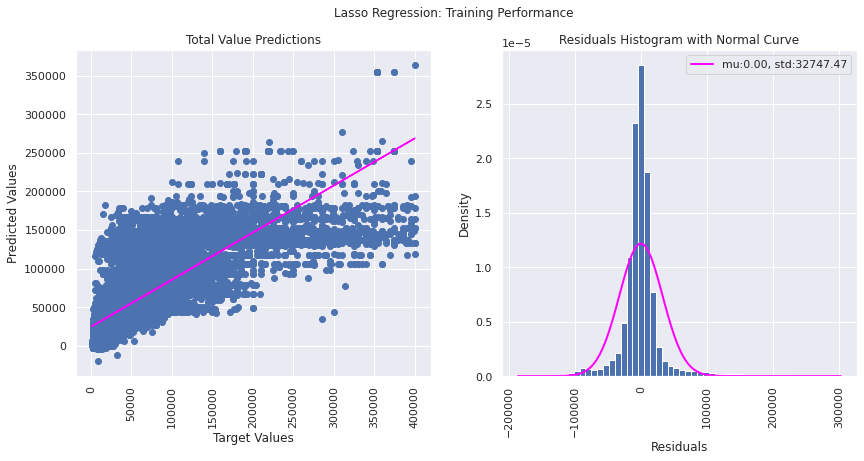

In [46]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Lasso Regression: Training Performance")

## Linear least squares with l2 regularization (aka Ridge)

In [47]:
# define the model
LRmodel = Ridge()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths"]
# save and fit the pipeline
RidgePipeline, train_x, train_y = fitLRModelPipeline(LRmodel, df, regression_cols)

Ridge() training time: 0.04114484786987305
Coefficients: 
 [  4400.8337049   -4400.83369807  37167.94849782 -35880.95485762
 -48058.55061096 158607.88613082  68717.21075287 -40637.90563486
 -35113.36454437  69622.36200364  70959.83236475 -42380.50209225
 -45147.08773086 -44893.18772321 -47663.72755536 -31029.28400457
 -22170.11626707 -20744.92149191 -11978.50351367 -25232.56523773
 -23640.50621393 -25536.2375136  -13866.89921232 -47763.89340616
 -42381.78135458  37929.14875313  86957.01833202  -7881.66405335
 -22354.70723629 -29905.72514436 -40712.36080368 -12925.99571856
   6736.13705115 256154.91849934  -4486.60256029 -35961.46232425
 -14567.24435109 -19936.71122873]
Intercept: 
 69546.52073002256


In [48]:
# save predictions from data
y_pred_train = RidgePipeline.predict(train_x)

In [49]:
# evaluate performance of predictions on target
evaluatePerformance(train_y, y_pred_train)

Mean squared error: 1178969176.13
Root Mean squared error: 34336.12
Mean absolute error: 19223.82
Median absolute error: 10306.85
Coefficient of determination: 0.57

Sample of 10 predictions vs. target:
Predicted values:  [144907.  48715.  42976.  69461.  80683.  37986.  17087. 142665.  17482.
  37986.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64


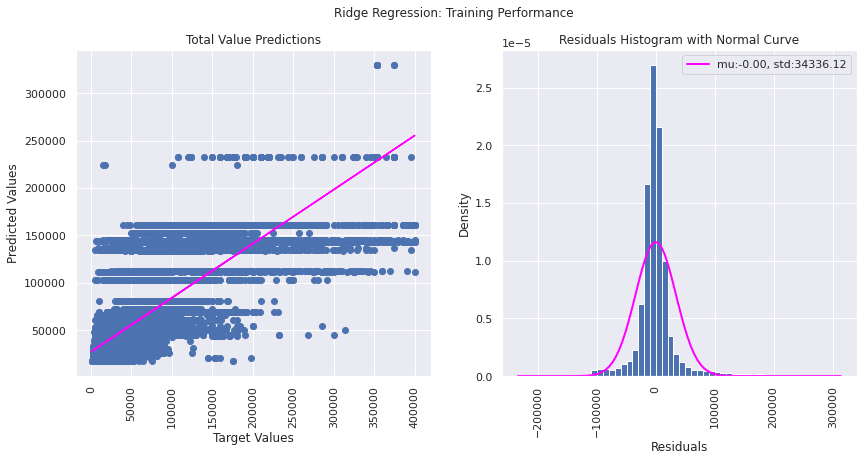

In [50]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Ridge Regression: Training Performance")

Running the model with more categorical variables.

In [51]:
# define the model
LRmodel = Ridge()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths", "Overall Condition", "Building Style", 
                   "Heat Type"]
# save and fit the pipeline
RidgePipeline, train_x, train_y = fitLRModelPipeline(LRmodel, df, regression_cols)

Ridge() training time: 0.10542154312133789
Coefficients: 
 [ 2.87883138e+03 -2.87883135e+03  3.18546121e+04 -2.99331598e+04
 -4.31407108e+04  1.20208561e+05  6.70231836e+04 -3.52482571e+04
 -3.69333852e+04  7.06505937e+04  6.96634872e+04 -3.65040051e+04
 -3.83611779e+04 -4.29833450e+04 -4.09581389e+04 -2.62759972e+04
 -1.72248729e+04 -1.59221340e+04 -6.97456787e+03 -2.04219304e+04
 -1.87681366e+04 -1.93546946e+04 -1.51562488e+04 -4.24933737e+04
 -4.06666203e+04  3.99825009e+04  8.62579112e+04 -3.07783706e+04
 -1.68150071e+04 -2.45657138e+04 -3.28940144e+04 -9.43475150e+03
  9.66888219e+03  2.08256375e+05  1.06222938e+02 -3.04958152e+04
 -1.42414301e+04 -1.71264708e+04 -2.37919832e+04 -2.04722015e+04
 -8.48087728e+03  2.19138924e+04  3.08311696e+04 -1.25239919e+04
  8.00047364e+03  3.14597467e+04 -1.53390579e+04  1.24614542e+04
  5.59063193e+04  9.90124244e+04 -1.56541169e+04 -3.88466887e+04
 -1.54706299e+04 -2.41076072e+04 -1.84594431e+03 -1.75907254e+04
  6.05789757e+03  1.95618574e+0

In [52]:
# save predictions from data
y_pred_train = RidgePipeline.predict(train_x)

In [53]:
# evaluate performance of predictions on target
evaluatePerformance(train_y, y_pred_train)

Mean squared error: 1073131371.59
Root Mean squared error: 32758.68
Mean absolute error: 18175.85
Median absolute error: 9527.37
Coefficient of determination: 0.61

Sample of 10 predictions vs. target:
Predicted values:  [136052.  33975.  43406.  69625.  76057.  35892.  17490. 145060.  19672.
  35892.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64


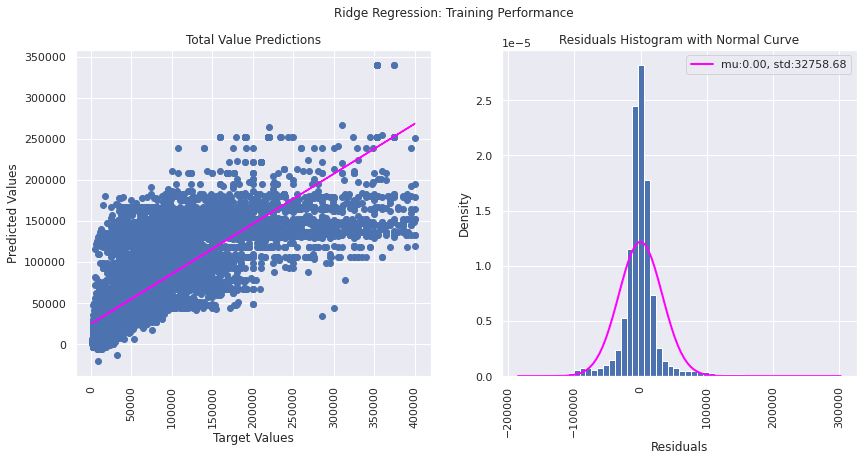

In [54]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Ridge Regression: Training Performance")

## Huber: Linear regression model that is robust to outliers.

In [55]:
# define the model
LRmodel = HuberRegressor()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths"]
# save and fit the pipeline
HuberPipeline, train_x, train_y = fitLRModelPipeline(LRmodel, df, regression_cols)

HuberRegressor() training time: 0.9307341575622559
Coefficients: 
 [  7335.2277539    6900.43221989  13993.41424725 -26584.92661131
 -43720.95893635 146650.01382728  56852.38562774 -31443.49327994
 -35370.84482197  69500.7463078   79695.71035104 -34095.99085901
 -37584.37258121 -43603.56528861 -39776.50366892 -26093.41202598
 -16479.7241745  -10448.50951584  -2558.52009029 -15259.78799601
 -17414.29535213 -14723.36749597 -18809.81936383 -39924.86857946
 -37604.40121553  39508.98728046  84456.99521253  10049.19482972
 -12896.03856251 -22458.16721683 -32138.81125491  -4898.29363246
  14727.70542821 121314.34363219  -1667.50222943 -28009.31158241
  -7950.81072586 -20997.539709  ]
Intercept: 
 53959.48334188777


In [56]:
# save predictions from data
y_pred_train = HuberPipeline.predict(train_x)

In [57]:
# evaluate performance of predictions on target
evaluatePerformance(train_y, y_pred_train)

Mean squared error: 1250470012.08
Root Mean squared error: 35361.99
Mean absolute error: 18109.54
Median absolute error: 8138.96
Coefficient of determination: 0.55

Sample of 10 predictions vs. target:
Predicted values:  [140990.  46035.  44380.  59627.  76022.  33285.  17139. 118147.  21083.
  33285.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64


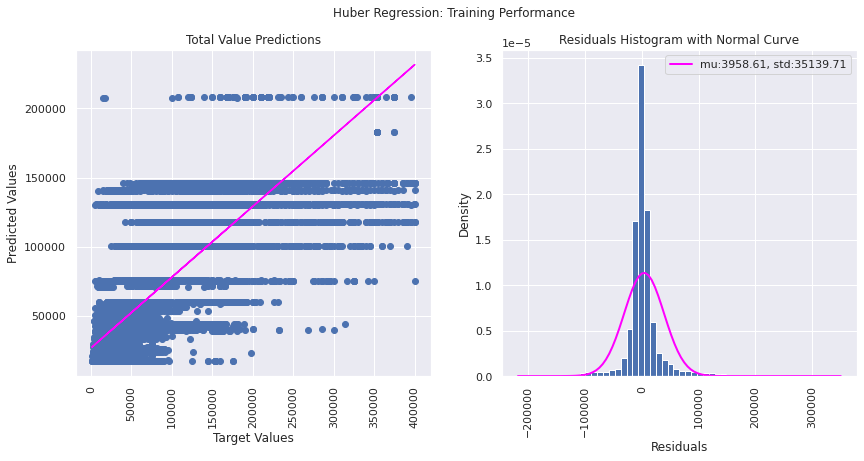

In [58]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Huber Regression: Training Performance")

Adding more categorical columns

In [59]:
# define the model
LRmodel = HuberRegressor()
# define the data that will be used in the model
regression_cols = ["Property Class Description", "Neighborhood", "Front", "Age",
                   "Total Living Area", "# of Fireplaces", "# of Beds", 
                   "TotalBaths", "Overall Condition", "Building Style", 
                   "Heat Type"]
# save and fit the pipeline
HuberPipeline, train_x, train_y = fitLRModelPipeline(LRmodel, df, regression_cols)

HuberRegressor() training time: 1.0655577182769775
Coefficients: 
 [ 14670.03163516  15739.5138924   14919.63194324 -20067.30763129
 -35672.05808913 123000.30831754  58968.78508897 -25564.01763333
 -28200.19689852  73450.56696678  83711.23361806 -27690.07703575
 -29500.85280974 -36041.84002478 -32801.29277838 -19621.6765569
 -10719.5504583   -5887.35300892   2555.8214409  -10523.01007473
 -11689.16947773  -8695.87178989 -15009.94423283 -33635.18431606
 -31861.0983956   43752.48397309  87991.18087786 -19930.44070027
  -7354.89547407 -16503.42228184 -24379.13472874   -676.3818074
  18041.62496021  14716.16185741   3711.72113249 -21762.53051432
  -5257.16801307 -15365.4999174   -6750.82218789   -761.85043631
   6742.931622    24261.28767766   6917.99885208   -487.35544299
  17555.46585069  26157.25495468  -3616.94852857  24565.6062434
  15272.41418266   1635.12909527  -8064.11214172 -20072.58747266
  -3614.79463897 -12987.56542973   -758.69354503  -8996.18903103
  -1242.32172488  21343.38

In [60]:
# save predictions from data
y_pred_train = HuberPipeline.predict(train_x)

In [61]:
# evaluate performance of predictions on target
evaluatePerformance(train_y, y_pred_train)

Mean squared error: 1155023228.41
Root Mean squared error: 33985.63
Mean absolute error: 17153.17
Median absolute error: 7721.32
Coefficient of determination: 0.58

Sample of 10 predictions vs. target:
Predicted values:  [138152.  36413.  44791.  65729.  72482.  32678.  19838. 117501.  22709.
  32678.]
Target values:  SBL
1003800004027000    175000.0
0907200002032000     10000.0
0896700003003000     33800.0
0797100006030000     51100.0
1334800003004000     75000.0
0887400003012000     35500.0
1016900005054111     25000.0
0788400002006000    295000.0
0907900002024000     25000.0
0887400003019000     35000.0
Name: Total Value, dtype: float64


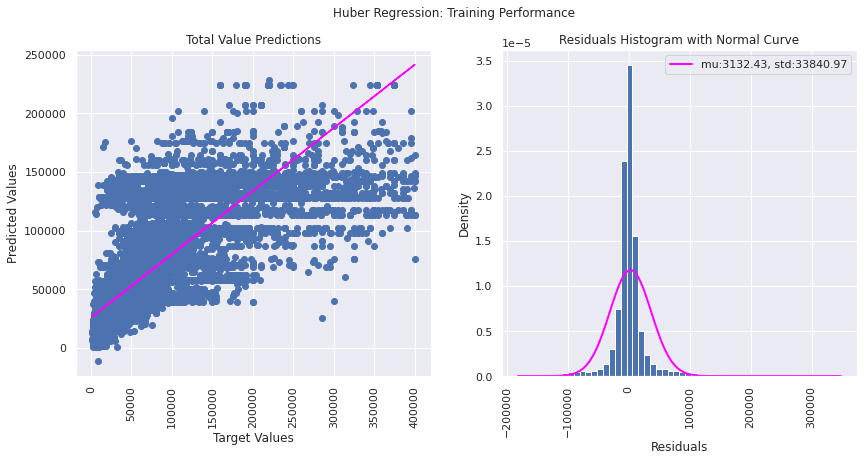

In [62]:
# create visualizations to evaluate performance
getPredictionPlot(train_y, y_pred_train, "Huber Regression: Training Performance")